# **Keras에서 VGGFace를 사용한 얼굴 인식**

---


이 수업에서는 얼굴 유사도를 비교하기 위해 Keras**에서 VGGFace를 사용한 **얼굴 인식을 사용한다. 사전 학습된 VGGFace 모델(수천 개의 얼굴에 대해 학습됨)을 로드하고 유사도 메트릭과 함께 사용하여 두 얼굴이 동일한 사람인지 여부를 정의한다.

1. 데이터를 다운로드하고 모듈을 가져옵니다
2. VGGFace 모델 정의 및 가중치 로드
3. 코사인 거리 함수 생성
4. 얼굴 유사성 확인
5. 원샷 학습을 통한 얼굴 인식
6. 웹캠을 사용하여 모델 테스트
7. Friends TV쇼의 비디오로 테스트합니다

관련 논문 - https://www.robots.ox.ac.uk/ ~vgg/출판물/2015/Parkhi15/parkhi15.pdf

## **1. Download our data, and import our modules**

In [5]:
!gdown --id 1RDw1BqsuZv4auJNv3iJ4ToIOnBq9WsVZ
!unzip -q face_recognition.zip

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1RDw1BqsuZv4auJNv3iJ4ToIOnBq9WsVZ
To: /content/face_recognition.zip
100% 4.84M/4.84M [00:00<00:00, 34.9MB/s]


In [6]:
# Import our libaries
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from PIL import Image
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, save_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

## **2. Define our VGGFace Model and load our weights**

In [7]:
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))

### **Load our VGG Face Weights**

We don't need to train our model if we can get the already trained 'weights'.

In [8]:
#you can download the pretrained weights from the following link
#https://drive.google.com/file/d/1CPSeum3HpopfomUEK1gybeuIVoeJT_Eo/view?usp=sharing
#or you can find the detailed documentation https://sefiks.com/2018/08/06/deep-face-recognition-with-keras/

!gdown --id 14eHppxprE1sCWmnjQ7LuijhAZQlb_Quz

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=14eHppxprE1sCWmnjQ7LuijhAZQlb_Quz
From (redirected): https://drive.google.com/uc?id=14eHppxprE1sCWmnjQ7LuijhAZQlb_Quz&confirm=t&uuid=d9afa2cf-11cd-4ed7-8001-5fdc92d71141
To: /content/vgg_face_weights.h5
100% 580M/580M [00:15<00:00, 36.7MB/s]


In [9]:
model.load_weights('vgg_face_weights.h5')

## **3. Create our cosine distance function**

![Image of Cosine Similarity](https://raw.githubusercontent.com/rajeevratan84/DeepLearningCV/master/cosine.JPG)
![Image of Cosine Similarity Formula](https://raw.githubusercontent.com/rajeevratan84/DeepLearningCV/master/cosinesim.JPG)

In [10]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

def findCosineSimilarity(source_representation, test_representation):
    a = np.matmul(np.transpose(source_representation), test_representation)
    b = np.sum(np.multiply(source_representation, source_representation))
    c = np.sum(np.multiply(test_representation, test_representation))
    return 1 - (a / (np.sqrt(b) * np.sqrt(c)))

# Our model that outputs the 2,622 embedding vector
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

## **4. Verify Facial Similarity**

#### **Define our verifyFace function where we load to images of faces and compare them.**

We set **epsilon** to be the threshold of whether our two faces are the same person. Setting a lower value makes it more strict with our face matching.

In [11]:
epsilon = 0.40

def verifyFace(img1, img2):
    # Get embedding/encoding for face1 and face2
    img1_representation = vgg_face_descriptor.predict(preprocess_image('./training_faces/%s' % (img1)))[0,:]
    img2_representation = vgg_face_descriptor.predict(preprocess_image('./training_faces/%s' % (img2)))[0,:]

    # Calculate the cosine similarity between the two embeddings
    cosine_similarity = findCosineSimilarity(img1_representation, img2_representation)

    f = plt.figure()
    f.add_subplot(1,2, 1)
    plt.imshow(image.load_img('./training_faces/%s' % (img1)))
    plt.xticks([]); plt.yticks([])
    f.add_subplot(1,2, 2)
    plt.imshow(image.load_img('./training_faces/%s' % (img2)))
    plt.xticks([]); plt.yticks([])
    plt.show(block=True)

    print("Cosine similarity: ",cosine_similarity)

    # If similarity score is less than the epsilon threshold
    if(cosine_similarity < epsilon):
        print("They are same person")
    else:
        print("They are not same person!")

### **Let's a run a few tests**

1/1 [==============================] - 1s 1s/step


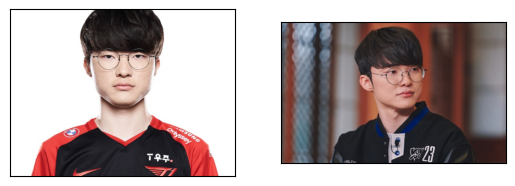

Cosine similarity:  0.7167806923389435
They are not same person!


In [12]:
# Let's compare two faces of the same person
verifyFace("1.jpg", "2.jpg")


1/1 [==============================] - 1s 605ms/step


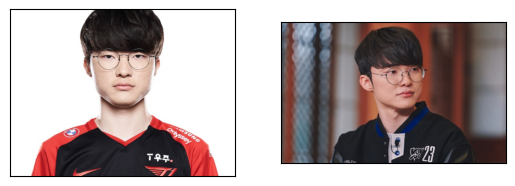

Cosine similarity:  0.7167806923389435
They are not same person!
1/1 [==============================] - 1s 610ms/step


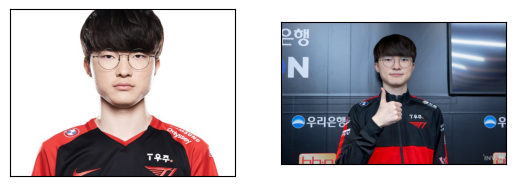

Cosine similarity:  0.6335191428661346
They are not same person!
1/1 [==============================] - 1s 579ms/step


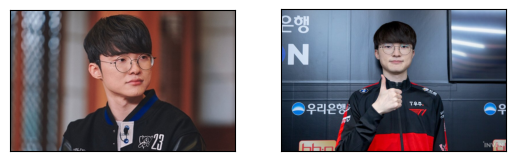

Cosine similarity:  0.18162161111831665
They are same person


In [14]:
# Let's now try it on 2nd picture of the same person
verifyFace("1.jpg", "2.jpg")
verifyFace("1.jpg", "3.jpg")
verifyFace("2.jpg", "3.jpg")

1/1 [==============================] - 1s 779ms/step


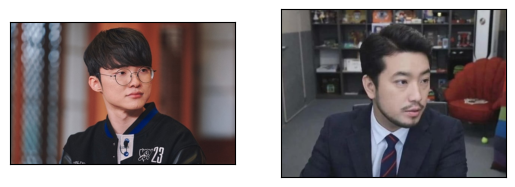

Cosine similarity:  0.20189577341079712
They are same person
1/1 [==============================] - 1s 606ms/step


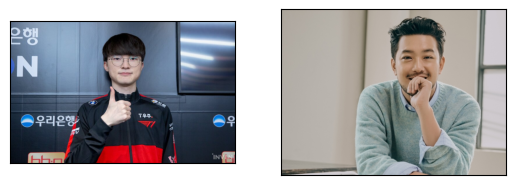

Cosine similarity:  0.24061572551727295
They are same person
1/1 [==============================] - 1s 625ms/step


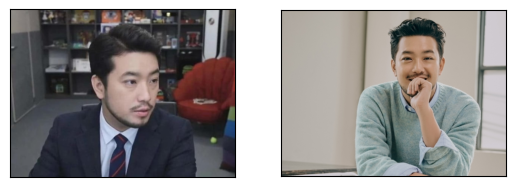

Cosine similarity:  0.45901650190353394
They are not same person!


In [15]:
# Now let's compare her face to Jennifer Lopez
verifyFace("2.jpg", "chim1.jpg")
verifyFace("3.jpg", "chim2.jpg")
verifyFace("chim1.jpg", "chim2.jpg")

# **5. Facial Recognition with One Shot Learning**
### **Extract faces from pictures of people**

#### **Instrutions:**
1. Place photos of people (one face visible) in the folder called "./people"
2. Replace my photo titled "Rajeev.jpg" with a piture of your face for testing on a webcam
3. Faces are extracted using the haarcascade_frontalface_default detector model
4. Extracted faces are placed in the folder called "./group_of_faces"
5. We are extracting the faces needed for our one-shot learning model, it will load 5 extracted faces

In [16]:
!gdown --id 1_X-V1Lp6qMAl_-9opsseieprD3Lhdq8U
!unzip -qq haarcascades.zip
!rm -rf people/.DS_Store

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1_X-V1Lp6qMAl_-9opsseieprD3Lhdq8U
To: /content/haarcascades.zip
100% 276k/276k [00:00<00:00, 66.5MB/s]


In [17]:
# Our Setup, Import Libaries, Create our Imshow Function and Download our Images
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Define our imshow function
def imshow(title = "Image", image = None, size = 8):
      w, h = image.shape[0], image.shape[1]
      aspect_ratio = w/h
      plt.figure(figsize=(size * aspect_ratio,size))
      plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
      plt.title(title)
      plt.show()

Collected 5 images


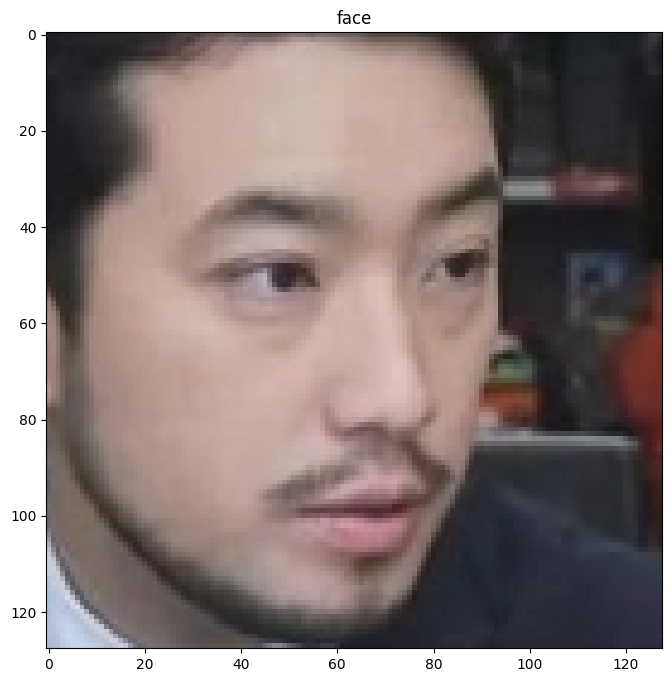

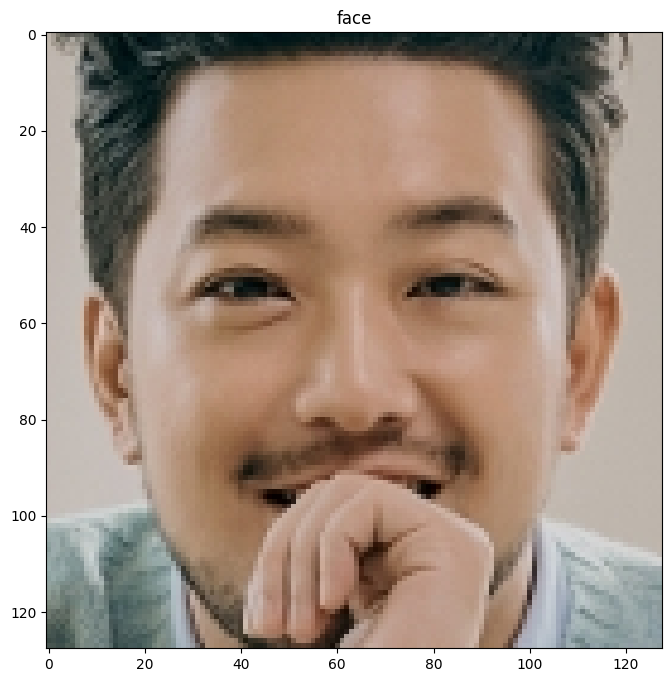

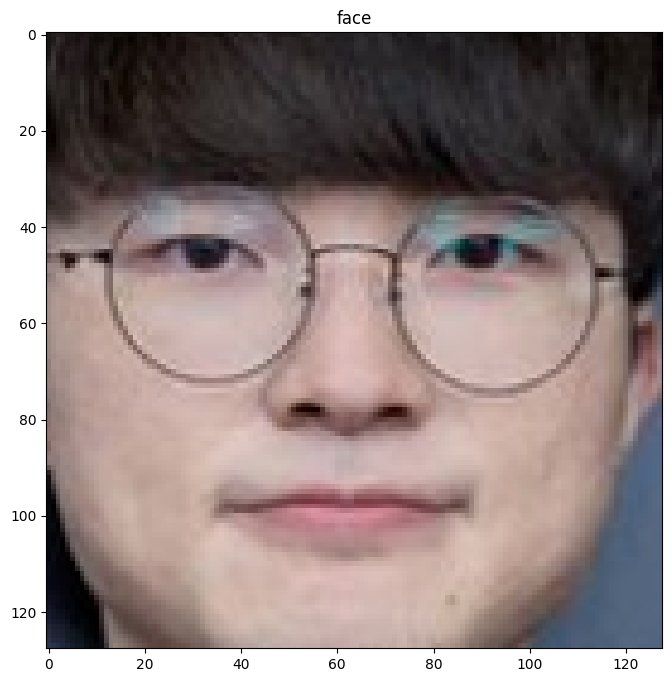

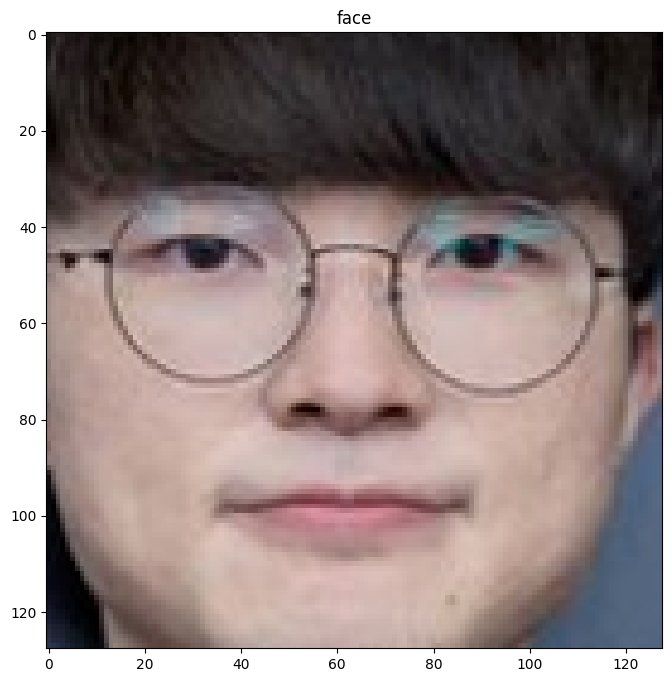

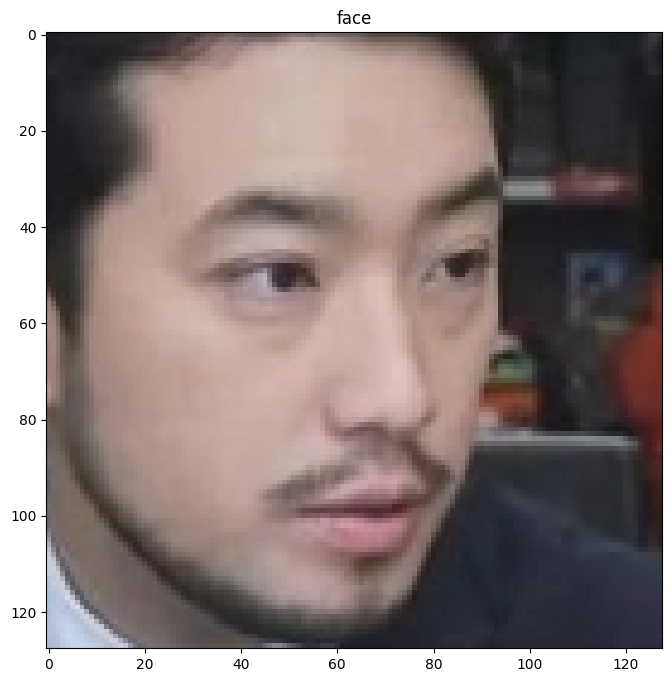

In [21]:
# The code below extracts faces from images and places them in the folder
import os
from os import listdir
from os.path import isfile, join

# Create a function to setup the directories we'll be storing our images
def makedir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        return None
    else:
        pass

# Loading out HAARCascade Face Detector
face_detector = cv2.CascadeClassifier('Haarcascades/haarcascade_frontalface_default.xml')

# Directory of image of persons we'll be extracting faces frommy
mypath = "./people/"
image_file_names = [f for f in listdir(mypath) if isfile(join(mypath, f))]
print("Collected " + str(len(image_file_names)) + " images")
makedir("./group_of_faces/")

for image_name in image_file_names:
    person_image = cv2.imread(mypath+image_name)
    face_info = face_detector.detectMultiScale(person_image, 1.3, 5)
    for (x,y,w,h) in face_info:
        face = person_image[y:y+h, x:x+w]
        roi = cv2.resize(face, (128, 128), interpolation = cv2.INTER_CUBIC)

    path = "./group_of_faces/" + "face_" + image_name
    cv2.imwrite(path, roi)
    imshow("face", roi)

### **Load our VGGFaceModel**
- This block of code defines the VGGFace model (which we use later) and loads the model

In [22]:
#author Sefik Ilkin Serengil
#you can find the documentation of this code from the following link: https://sefiks.com/2018/08/06/deep-face-recognition-with-keras/

import numpy as np
import cv2
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, save_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from os import listdir

def preprocess_image(image_path):
    """Loads image from path and resizes it"""
    img = load_img(image_path, target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))

#you can download pretrained weights from https://drive.google.com/file/d/1CPSeum3HpopfomUEK1gybeuIVoeJT_Eo/view?usp=sharing
from tensorflow.keras.models import model_from_json
model.load_weights('vgg_face_weights.h5')

vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

model = vgg_face_descriptor

print("Model Loaded")

Model Loaded


## **6. Test model using your Webcam**
This code looks up the faces you extracted in the "group_of_faces" folder and uses the similarity (Cosine Similarity) to detect which faces is most similar to the one being extracted with your webcam.

In [23]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


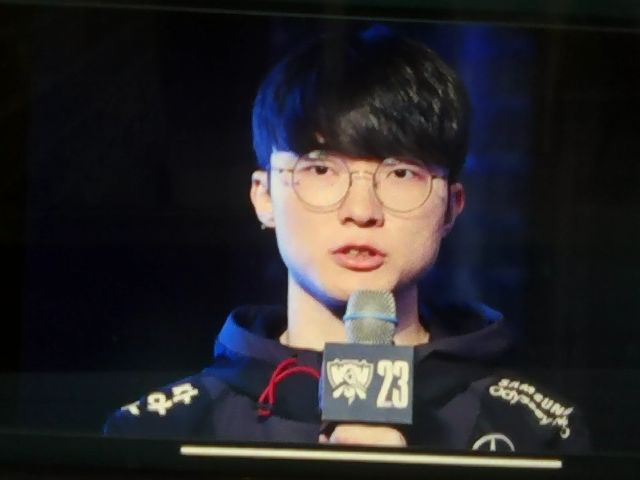

In [24]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

1/1 [==============================] - 1s 1s/step
Face representations retrieved successfully


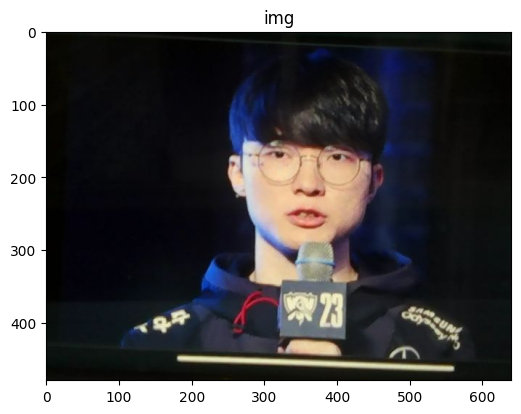

In [25]:
#points to your extracted faces
people_pictures = "./group_of_faces/"

all_people_faces = dict()

for file in listdir(people_pictures):
    person_face, extension = file.split(".")
    try:
      all_people_faces[person_face] = model.predict(preprocess_image('./group_of_faces/%s.jpg' % (person_face)))[0,:]
    except:
      pass

print("Face representations retrieved successfully")

def findCosineSimilarity(source_representation, test_representation):
    a = np.matmul(np.transpose(source_representation), test_representation)
    b = np.sum(np.multiply(source_representation, source_representation))
    c = np.sum(np.multiply(test_representation, test_representation))
    return 1 - (a / (np.sqrt(b) * np.sqrt(c)))

img = cv2.imread('photo.jpg')
faces = face_detector.detectMultiScale(img, 1.3, 5)

for (x,y,w,h) in faces:
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2) #draw rectangle to main image
    detected_face = img[int(y):int(y+h), int(x):int(x+w)] #crop detected face
    detected_face = cv2.resize(detected_face, (224, 224)) #resize to 224x224

    img_pixels = image.img_to_array(detected_face)
    img_pixels = np.expand_dims(img_pixels, axis = 0)
    img_pixels /= 255

    captured_representation = model.predict(img_pixels)[0,:]

    found = 0
    for i in all_people_faces:
        person_name = i
        representation = all_people_faces[i]

        similarity = findCosineSimilarity(representation, captured_representation)
        if(similarity < 0.35):
            cv2.putText(img, person_name[5:], (int(x+w+15), int(y-12)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
            found = 1
            break

    #connect face and text
    cv2.line(img,(int((x+x+w)/2),y+15),(x+w,y-20),(255, 0, 0),1)
    cv2.line(img,(x+w,y-20),(x+w+10,y-20),(255, 0, 0),1)

    if(found == 0): #if found image is not in our people database
        cv2.putText(img, 'unknown', (int(x+w+15), int(y-12)), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

imshow('img',img)



## **7. Test on video from the Friends TV show**

Since we're using the Friends TV Series characters, let's extract the faces from the images I placed in the "./friends" folder

In [26]:
!find . -name '.DS_Store' -type f -delete

Collected image names


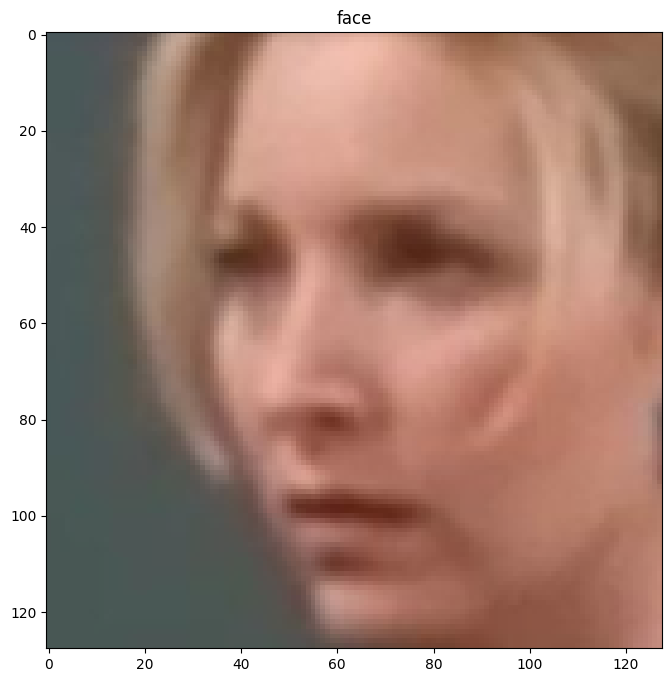

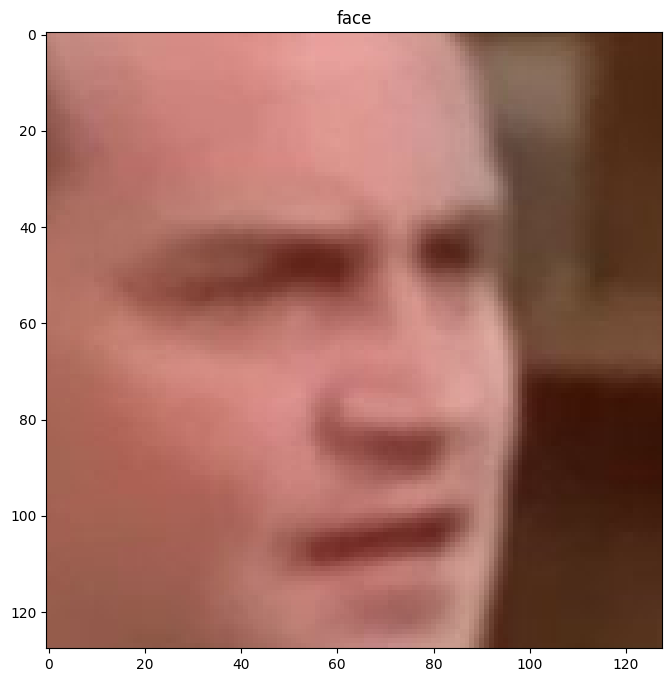

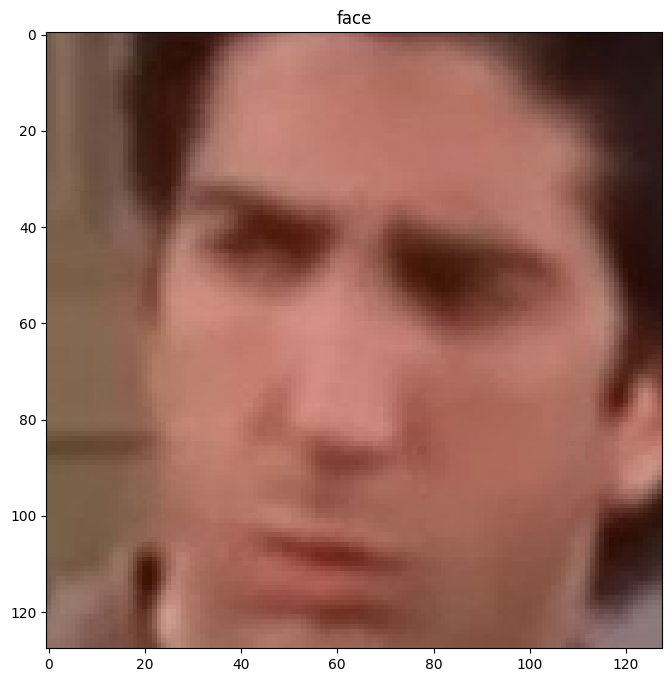

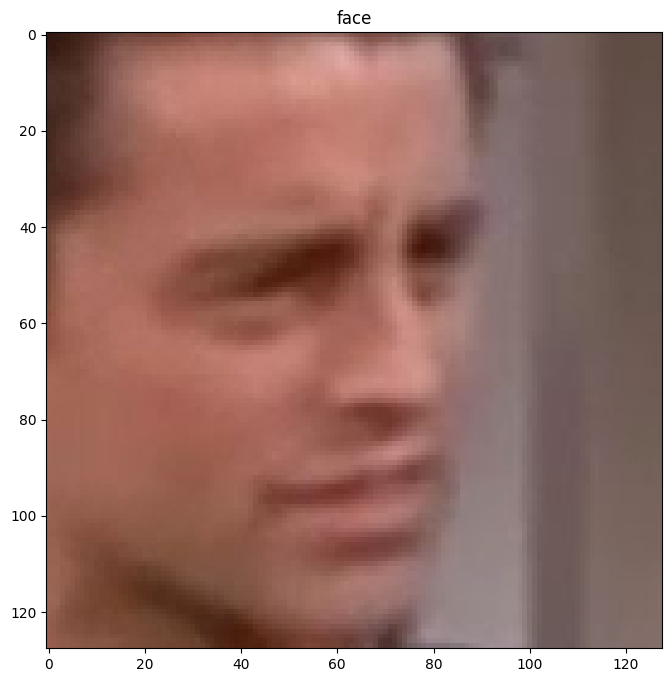

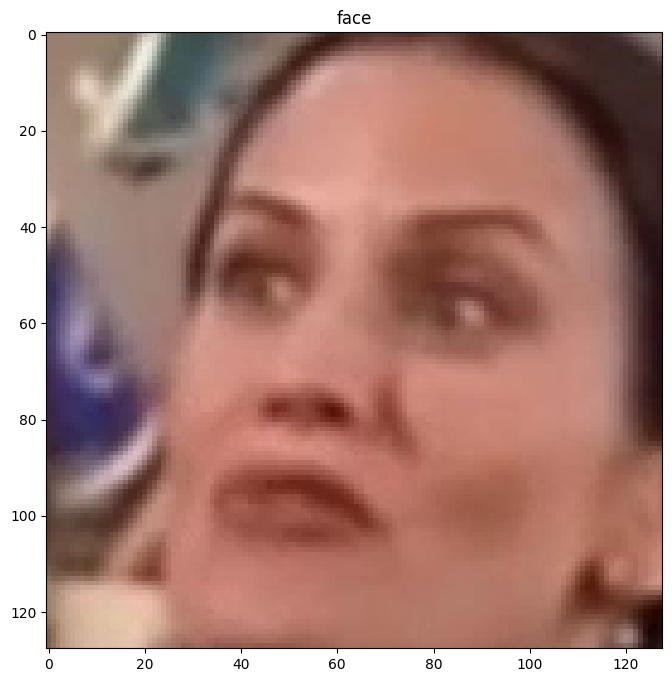

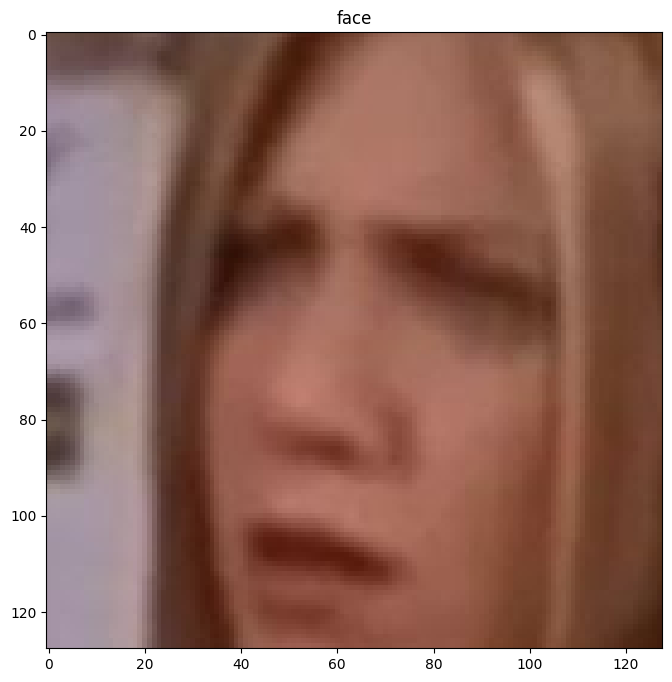

In [27]:
from os import listdir
from os.path import isfile, join
import cv2

# Loading out HAARCascade Face Detector
face_detector = cv2.CascadeClassifier('Haarcascades/haarcascade_frontalface_default.xml')

# Directory of image of persons we'll be extracting faces frommy
mypath = "./friends/"
image_file_names = [f for f in listdir(mypath) if isfile(join(mypath, f))]
print("Collected image names")
makedir("friends_faces/")

for image_name in image_file_names:
    person_image = cv2.imread(mypath+image_name)
    face_info = face_detector.detectMultiScale(person_image, 1.3, 5)
    for (x,y,w,h) in face_info:
        face = person_image[y:y+h, x:x+w]
        roi = cv2.resize(face, (128, 128), interpolation = cv2.INTER_CUBIC)
    path = "friends_faces/" + "face_" + image_name
    cv2.imwrite(path, roi)
    imshow("face", roi)

Again, we load our faces from the "friends_faces" directory and we run our face classifier model our test video

1/1 [==============================] - 1s 1s/step
Face representations retrieved successfully
1/1 [==============================] - 1s 596ms/step


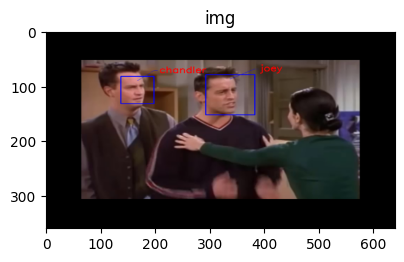

1/1 [==============================] - 1s 630ms/step


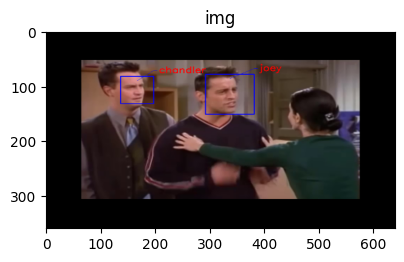

1/1 [==============================] - 1s 601ms/step


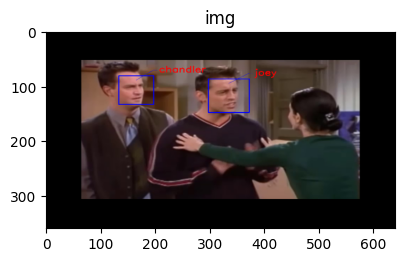

1/1 [==============================] - 1s 590ms/step


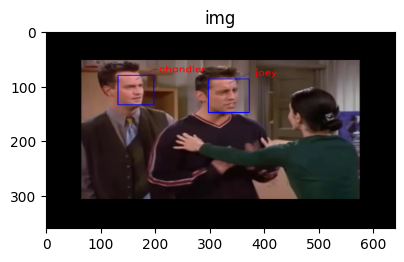

1/1 [==============================] - 1s 605ms/step


In [ ]:
#points to your extracted faces
people_pictures = "./friends_faces/"

all_people_faces = dict()

for file in listdir(people_pictures):
    person_face, extension = file.split(".")
    try:
      all_people_faces[person_face] = model.predict(preprocess_image('./friends_faces/%s.jpg' % (person_face)))[0,:]
    except:
      pass

print("Face representations retrieved successfully")

def findCosineSimilarity(source_representation, test_representation):
    a = np.matmul(np.transpose(source_representation), test_representation)
    b = np.sum(np.multiply(source_representation, source_representation))
    c = np.sum(np.multiply(test_representation, test_representation))
    return 1 - (a / (np.sqrt(b) * np.sqrt(c)))

cap = cv2.VideoCapture('Friends.mp4')
frame_count = 0

# Get the height and width of the frame (required to be an integer)
w = int(cap.get(3)) + 200
h = int(cap.get(4)) + 200

# Define the codec and create VideoWriter object.The output is stored in 'outpy.avi' file.
out = cv2.VideoWriter('friends_face_recognition.avi', cv2.VideoWriter_fourcc('M','J','P','G'), 30, (w, h))

while(True):
  ret, img = cap.read()
  if ret:
    #img = cv2.resize(img, (320, 180)) # Re-size video to as smaller size to improve face detection speed
    img = cv2.copyMakeBorder(img, 100, 100, 100, 100, cv2.BORDER_CONSTANT, value=[0,0,0])
    faces = face_detector.detectMultiScale(img, 1.3, 5)
    frame_count+=1
    for (x,y,w,h) in faces:
      if w > 13:
          cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2) #draw rectangle to main image

          detected_face = img[int(y):int(y+h), int(x):int(x+w)] #crop detected face
          detected_face = cv2.resize(detected_face, (224, 224)) #resize to 224x224

          img_pixels = image.img_to_array(detected_face)
          ls = image.img_to_array(detected_face)
          img_pixels = np.expand_dims(img_pixels, axis = 0)
          img_pixels /= 255

          captured_representation = model.predict(img_pixels)[0,:]

          found = 0
          for i in all_people_faces:
            person_name = i
            representation = all_people_faces[i]

            similarity = findCosineSimilarity(representation, captured_representation)
            if(similarity < 0.30):
                cv2.putText(img, person_name[5:], (int(x+w+15), int(y-12)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
                found = 1
                break

            #connect face and text
            cv2.line(img,(int((x+x+w)/2),y+15),(x+w,y-20),(255, 0, 0),1)
            cv2.line(img,(x+w,y-20),(x+w+10,y-20),(255, 0, 0),1)

    imshow('img',cv2.resize(img, (640, 360)))
    # Write the frame into the file 'output.avi'
    out.write(img)
  else:
    break

cap.release()
out.release()